In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
from pydantic import BaseModel, Field

# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(None, description="Why is this query relevant for the user's request.")

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("What the hell is Soccer and why do some people call it Soccer and others Football?")
print(output.search_query)
print(output.justification)

difference between soccer and football
This query addresses the confusion surrounding the terms 'soccer' and 'football', giving insights into their origins and why different cultures use different names.


In [4]:
# Define a Tool
def multiply(x: int, y: int) -> int:
    """ The tool is used to multiply two numbers, x and y.
    """
    return x * y

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

msg = llm_with_tools.invoke("What is 5 times 8?")

# Get the tool calls
msg.tool_calls

[{'name': 'multiply',
  'args': {'x': 5, 'y': 8},
  'id': 'call_yl2MyORyABBfmfKYX7qPkxu2',
  'type': 'tool_call'}]

### Basic Prompt Chaining

In [5]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [6]:
# Nodes
def generate_joke(state: State):
    """Generates the initial joke."""
    
    msg = llm.invoke(f"Generate a joke about: {state['topic']}")
    return {'joke': msg.content}

def improve_joke(state: State):
    """Improves the joke."""
    
    msg = llm.invoke(f"Now make this joke funnier by adding a crying baby into the story: {state['joke']}")
    return {'improved_joke': msg.content}

def polish_joke(state: State):
    """Final polishing of the joke"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {'final_joke': msg.content}

# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    if "?" in state['joke'] or "!" in state['joke']:
        return "Pass" # custom 
    return "Fail"

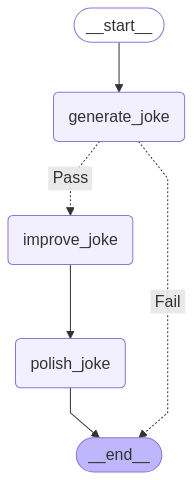

In [7]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

# Build the workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges
workflow.add_edge("__start__", "generate_joke")
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", "__end__")

workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": "__end__"}
)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [8]:
state = chain.invoke({'topic': "sun"})

In [9]:
state

{'topic': 'sun',
 'joke': 'Why did the sun go to school?\n\nBecause it wanted to get a little brighter!',
 'improved_joke': 'Why did the sun go to school? \n\nBecause it wanted to get a little brighter! \n\nBut just as it was about to ace its first test, a crying baby whipped out a sun-shaped rattle and yelled, "It\'s too hot in here!" The sun couldn\'t help but feel dimmed by the competition for attention!',
 'final_joke': 'Why did the sun go to school? \n\nBecause it wanted to get a little brighter! \n\nBut just as it was about to ace its first test, a crying baby whipped out a sun-shaped rattle and yelled, "It\'s too hot in here!" To the sun\'s shock, the baby\'s rattle turned out to be a secret alien device that could control the weather. Suddenly, it began to snow in the classroom, and the sun thought, "I didn’t sign up for a chilling experience!" Just then, the teacher declared, "Congratulations, class! You\'ve just passed the coolest exam ever!" The sun realized that sometimes, 

### Parallelization

In [10]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [11]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke."""

    msg = llm.invoke(f"Write a joke about: {state['topic']}")
    return {'joke': msg.content}

def call_llm_2(state: State):
    """Second LLM call to generate story."""

    msg = llm.invoke(f"Write a story about: {state['topic']}")
    return {'story': msg.content}

def call_llm_3(state: State):
    """Third LLM call to generate poem."""

    msg = llm.invoke(f"Write a poem about: {state['topic']}")
    return {'poem': msg.content}

def aggregator(state: State):
    """Combine the joke, story, and a poem into a single output."""

    combined = f"Here is a joke, a story, and a poem about {state['topic']}: \n\n"
    combined += f"JOKE: {state['joke']}\n\n"
    combined += f"STORY: {state['story']}\n\n"
    combined += f"POEM: {state['poem']}\n\n"
    
    return {'combined_output': combined}

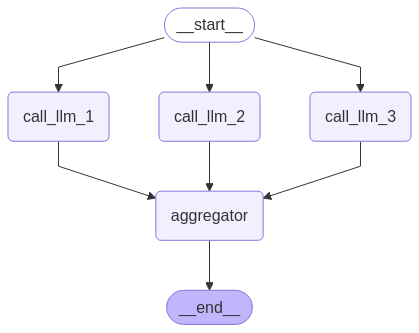

In [12]:
# Build the workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)

parallel_builder.add_node("aggregator", aggregator)

# Add edges
parallel_builder.add_edge("__start__", "call_llm_1")
parallel_builder.add_edge("__start__", "call_llm_2")
parallel_builder.add_edge("__start__", "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", "__end__")

# Compile
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [13]:
out = parallel_workflow.invoke({'topic': 'moon'})

In [14]:
print(out['combined_output'])

Here is a joke, a story, and a poem about moon: 

JOKE: Why did the moon break up with the sun?

Because it needed space! 🌒✨

STORY: ### Beneath the Silver Glow

Once upon a time, in a small village named Eldergrove, nestled in the heart of a vast forest, people lived simple, content lives. Among the villagers was a girl named Elara, known for her curious spirit and captivating tales about the world beyond the trees. Her favorite stories were about the moon, which she believed was a celestial guardian watching over them.

Every night, Elara would climb the hill behind her house, a place where the thick canopy gave way to an unbroken sky, and there she would sit, whispering her dreams to the glowing moon. With its silver light spilling like water over the landscape, Elara felt an unbreakable connection to the mysterious orb above, a bond forged through countless nights of shared solitude and reflection.

One evening, as she made her nightly ascent, Elara noticed something unusual. The m

### Routing

In [15]:
from typing_extensions import Literal, Optional

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Optional[Literal["poem", "story", "joke"]] = Field(None, description="The next step in the routing process.")

# Augment the LLM with schema above for structured output
router = llm.with_structured_output(Route)

In [16]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [17]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def llm_call_1(state: State):
    """Write a story."""

    result = llm.invoke(state['input'])
    return {'output': result.content}

def llm_call_2(state: State):
    """Write a joke."""

    result = llm.invoke(state['input'])
    return {'output': result.content}

def llm_call_3(state: State):
    """Write a poem."""

    result = llm.invoke(state['input'])
    return {'output': result.content}

def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(
                content=state['input']
            )
        ]
    )
    return {'decision': decision.step}

# Conditioinal edge function to route to the appropriate node
def route_decision(state: State):
    # Return the route name you want to go 
    if state['decision'] == 'story':
        return "llm_call_1"
    if state['decision'] == 'joke':
        return "llm_call_2"
    if state['decision'] == 'poem':
        return "llm_call_3"

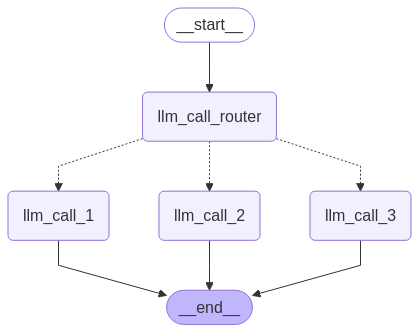

In [18]:
# Build the workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_router", llm_call_router)
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)

# Add edges
router_builder.add_edge("__start__", "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router", route_decision, {"llm_call_1": "llm_call_1", "llm_call_2": "llm_call_2", "llm_call_3": "llm_call_3"})
router_builder.add_edge("llm_call_1", "__end__")
router_builder.add_edge("llm_call_2", "__end__")
router_builder.add_edge("llm_call_3", "__end__")

# Compile
router_workflow = router_builder.compile()

# Show workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [19]:
out = router_workflow.invoke({'input': "generate a joke about jupyter"})

In [20]:
out['output']

'Why did the Jupyter notebook break up with the text editor?\n\nBecause it found someone who could give it more cells!'

### Orchestrator Worker

In [21]:
from typing import Annotated, List
import operator

# Schema for structured outputs to use in planning
class Section(BaseModel):
    name: str = Field(description="Name for this section of report."),
    description: str = Field(description="Brief overview of the main topics and concepts to be covered in this section.")

class Sections(BaseModel):
    sections: List[Section] = Field(description="Sections of the report.")

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

/opt/homebrew/Cellar/jupyterlab/4.4.0/libexec/lib/python3.13/site-packages/pydantic/json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Name for this section of report.'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [22]:
# Graph state
class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[
        list, operator.add
    ]
    final_report: str

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [23]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}.")
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate sectio
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(content=f"Here is the section name: {state['section'].name} and its description: {state['section'].description}")
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections."""

    # List of all completed sections
    completed_sections = state['completed_sections']

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n----\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section for the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

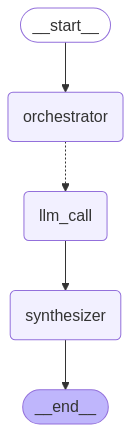

In [24]:
from langgraph.constants import Send

# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Nodes
orchestrator_worker_builder.add_node("synthesizer", synthesizer)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("orchestrator", orchestrator)

# Edges
orchestrator_worker_builder.add_edge("__start__", "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]

)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", "__end__")

# Compile
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [25]:
state = orchestrator_worker.invoke({"topic": "in depth analysis of red ants"})

/opt/homebrew/Cellar/jupyterlab/4.4.0/libexec/lib/python3.13/site-packages/pydantic/json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Name for this section of report.'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [26]:
from IPython.display import Markdown

Markdown(state["final_report"])

### Introduction to Red Ants

Red ants, belonging to the subfamily Formicinae, are a diverse group of social insects known for their striking coloration and complex behaviors. They are classified under the family Formicidae, which encompasses all ants, with the genus Solenopsis being one of the most well-recognized among red ant species. Commonly, when referring to red ants, one might think of the notorious red imported fire ant (Solenopsis invicta), but other species exhibit similar reddish hues and social structures.

**Classification**

The classification of red ants begins at the domain level, with these insects belonging to the Animalia kingdom, characterized as multicellular organisms that are heterotrophic and capable of movement. Moving down the taxonomic hierarchy, they fall under the phylum Arthropoda, which encompasses invertebrates with exoskeletons, segmented bodies, and jointed appendages. They belong to the class Insecta, order Hymenoptera—which also includes bees and wasps—and, ultimately, the subfamily Formicinae, which is filled with a variety of socially complex ant species.

**Habitats**

Red ants are adaptable and can thrive in a variety of habitats. They are commonly found in warm, temperate regions, often in soil, decaying wood, or beneath stones. These ants prefer environments that provide sufficient foraging opportunities, such as forests, grasslands, and urban areas. Their nests are typically constructed underground or in decaying wood, where they create an intricate system of tunnels and chambers. These nests serve as both a sanctuary and a hive for their colony, housing the queen, workers, and larvae.

**General Characteristics**

Red ants are notable for their distinctive bright red to brown coloration, which serves as a warning signal to potential predators due to their aggressive behavior and painful sting. Their body structure typically includes a well-defined waist, compound eyes, and long antennae which are crucial for communication and navigation. As social insects, red ants exhibit strong cooperative behaviors within their colonies, including foraging, nest maintenance, and brood care.

In terms of behavior, red ants are known for their defensive and aggressive tendencies when their nests are threatened. This makes them significant both ecologically and economically, as they can impact local ecosystems and occasionally disrupt human activities through their aggressive nature and tendency to swarm. Additionally, their role as scavengers and predators helps maintain the balance within their ecosystems.

Overall, understanding red ants—through their classification, habitats, and characteristics—provides insight not only into their biological attributes but also into their ecological roles and interactions with humans.

----

### Biology and Physiology

Red ants, belonging primarily to the genus **Formica** and **Solenopsis**, are fascinating creatures that exhibit a range of complex biological and physiological traits. Understanding these aspects is crucial for appreciating their role in ecosystems, their behavior, and their interactions with the environment.

#### Anatomy

The anatomy of red ants is distinctly adapted for their survival and social lifestyle. Adult ants have a three-part body segmented into the head, thorax, and abdomen. The head houses the mandibles, which are powerful pincers used for foraging, defense, and carrying objects. Their compound eyes provide a wide field of vision, while the antennae serve as vital sensory organs, facilitating communication and environmental interaction.

Red ants possess a well-developed exoskeleton made of chitin, which provides structural support and protection from predators. A notable feature is their sting, produced by a specialized structure called the ovipositor in female ants, which is utilized for defense and subduing prey. 

Internally, red ants have an intricate system comprising a dorsal blood vessel functioning as a heart, a simple yet effective digestive system, and a network of tracheae that facilitate respiration. Their physiology is adapted to support their active lifestyle, exhibiting a high metabolic rate that corresponds to their energetic requirements.

#### Lifecycle

The lifecycle of red ants follows a complete metamorphosis, consisting of four primary stages: egg, larva, pupa, and adult. The reproductive cycle begins with the queen, who is primarily responsible for reproduction within the colony. After mating during nuptial flights, the queen stores sperm and can fertilize eggs as needed throughout her life.

Eggs are initially laid in the colony and develop into larvae, which are fed and cared for by worker ants. Larvae undergo several instars before entering the pupal stage, where they undergo significant morphological changes. The duration of each stage can vary significantly based on environmental conditions, colony size, and species.

Once the adults emerge, their roles within the colony are defined by social structure, often categorizing them into castes such as workers, soldiers, and reproductive individuals. Worker ants are responsible for foraging, nest maintenance, and caring for the young, while soldiers provide defense against threats.

#### Reproductive Habits

The reproductive habits of red ants are characterized by complex social behaviors and seasonal patterns. Mating typically occurs during a specific time of year, often triggered by environmental cues such as temperature and humidity. Males are short-lived, generally dying shortly after mating, while queens can live for years, sustaining the colony across multiple generations.

After a queen has mated and established her colony, she begins to lay eggs in cycles, producing a significant number of offspring that can lead to rapid population growth under optimal conditions. The timing and success of reproduction are crucial for ensuring the survival of the colony, as it directly influences the colony's ability to compete for resources and defend against predators.

In summary, the biology and physiology of red ants offer an intricate view into their adaptive strategies and social structure. Through their specialized anatomy, distinct lifecycle stages, and sophisticated reproductive habits, red ants exemplify the complexities of communal living in the insect world. Understanding these elements is pivotal for ecological studies and pest management strategies concerning these industrious ants.

----

### Behavioral Patterns of Red Ants

Red ants, specifically those belonging to the genus *Solenopsis*, exhibit a variety of intricate behaviors that contribute to their survival and effectiveness as social insects. This section analyzes their foraging habits, nesting behaviors, social structures, and communication methods, providing insight into the complex dynamics of their colonies.

#### Foraging Behavior

Foraging is a critical activity for red ants, allowing them to locate and transport food back to their nests. These ants display a remarkable ability to collaborate during foraging, employing both individual and collective strategies. Typically, scouts venture out from the nest to search for food sources, which include insects, seeds, and organic debris. Once they locate food, scouts deposit pheromones to create a chemical trail, guiding other foragers to the resource. This collective foraging strategy maximizes efficiency and ensures that resources are rapidly utilized.

#### Nesting Habits

Red ants construct nests that can vary significantly in sophistication, depending on environmental conditions. These nests may be built underground, in rotting wood, or in other sheltered locations. The construction involves recruiting worker ants who work cooperatively to dig, transport materials, and defend the nest. Nest architecture often reflects the species' adaptation to its habitat, with some species exhibiting more elaborate structures to regulate temperature and humidity. The maintenance of nests is a continuous activity, as the colony works together to repair and expand their living space.

#### Social Structure

The social structure of red ant colonies is highly organized, typically centered around a queen, worker ants, and, during reproductive seasons, male ants. The queen's primary function is reproduction, while worker ants undertake various tasks such as foraging, nest-building, and brood care. The division of labor is flexible; workers can switch roles based on the colony's needs. This dynamic social structure enhances the colony’s resilience and efficiency, allowing it to respond to environmental changes and threats more effectively.

#### Communication Methods

Communication among red ants is predominantly chemical, utilizing pheromones to convey information regarding food availability, alarm signals, and reproductive status. These chemical signals enable the ants to coordinate activities such as foraging, nest defense, and the rearing of young. In addition to pheromones, red ants may also engage in tactile communication through physical contact and the use of their antennae, which help in recognizing nestmates and territory. Acoustic signals, while less common, have also been observed in some species in the context of alarm and mating.

### Conclusion

The behavioral patterns of red ants illustrate a highly adaptive and cooperative society, optimized for survival and efficiency. Their foraging strategies, nesting habits, social organization, and communication methods highlight the complexity of their interactions and their ability to thrive in diverse environments. Understanding these behaviors is vital for researchers studying ecological dynamics and the evolutionary success of social insects.

----

### Ecological Role of Red Ants

Red ants, primarily belonging to the genus *Solenopsis*, play a significant role in various ecosystems, contributing to ecological balance and integrity. Their ecological importance can be observed through multiple facets including soil aeration, nutrient cycling, pest control, and their interactions with other species, both as competitors and as mutualistic partners.

#### Soil Aeration and Nutrient Cycling

One of the most critical functions of red ants in the ecosystem is their ability to aerate the soil. Through their nesting and foraging activities, red ants help to create a network of tunnels that improve soil structure. This aeration enhances water infiltration and root penetration, ultimately benefiting plant growth. As red ants transport organic materials, including dead insects and plant matter, to their nests, they contribute to nutrient cycling by decomposing these materials. The presence of red ants can increase the availability of nutrients in the soil, fostering a more fertile habitat for various plant species.

#### Pest Control

Red ants also play a vital role in pest control within their habitats. They are known predators of various insect species, including pests that can be detrimental to agricultural crops. By naturally regulating pest populations, red ants contribute to a healthier environment that facilitates biodiversity. However, it is important to note that their predatory behavior can also lead to competitive exclusion and population declines in certain insect species, highlighting the duality of their ecological role.

#### Interactions with Other Species

Red ants exhibit complex interactions with numerous species, forming both competitive and symbiotic relationships. They compete with other ant species for resources, which can influence community structure and species composition within their habitats. In mutualistic relationships, red ants are known to care for aphids, protecting them from predators in exchange for honeydew— a sugary secretion produced by aphids. This interaction not only supports the survival of aphids but also enhances food resources for red ants, demonstrating the intricate web of relationships that define the ecosystem.

Additionally, red ants serve as prey for various vertebrates, including birds and small mammals, positioning them as an integral part of the food web. By providing a food source for these predators, red ants help to sustain other populations within their ecosystem.

#### Conclusion

In summary, red ants fulfill numerous essential functions within their ecosystems. Their activities contribute to soil health, pest regulation, and a dynamic network of species interactions. Understanding the ecological role of red ants is crucial for appreciating the complexity of their environments and the overarching significance of biodiversity. Further research into their behavior and ecological impacts will continue to illuminate their importance in maintaining ecosystem resilience and integrity.

----

### Impact on Humans

Red ants, specifically species such as the Red Imported Fire Ant (Solenopsis invicta) and other various forms of red ants, have a significant impact on human activities, particularly in the realms of agriculture, pest control, and health risks associated with their stings.

#### Agriculture

Red ants can have both beneficial and detrimental effects on agriculture. On one hand, certain species contribute to soil aeration and the decomposition of organic matter, which can enhance soil fertility. Their predatory behavior can also provide a degree of biological pest control by feeding on various agricultural pests. This natural pest-management service can be particularly valuable in reducing agricultural losses and minimizing chemical pesticide use.

Conversely, red ants can become pests themselves, damaging crops and disrupting farming practices. They often invade agricultural lands in search of food, particularly when they are attracted to spilled grains or sugary substances. Their nests can compromise the quality of the land, leading to challenges in planting and harvesting. In some cases, red ants may even target seedlings and young plants, creating economic losses for farmers.

#### Pest Control

In the realm of pest control, red ants have been both allies and adversaries. Their predation on herbivorous insects can be seen as beneficial; however, their presence can disrupt local ecosystems if they become invasive. For instance, the Red Imported Fire Ant has established populations in various regions outside their native range, often outcompeting local species for resources and altering the ecological balance. This invasive behavior may lead to a decrease in biodiversity and negatively impact local agricultural practices.

While some farmers may experiment with using red ants as a natural pest management tool, this approach must be undertaken carefully to weigh the potential for adverse ecological impacts.

#### Health Risks from Stings

One of the most concerning aspects of red ants, particularly fire ants, is their potent sting. Their bites and stings can cause significant pain, characterized by a burning sensation and the development of itchy welts. For many, especially those with allergies to their venom, stings can result in severe reactions, including anaphylaxis, which can be life-threatening without prompt medical intervention. This health risk makes the containment and management of red ant populations essential, particularly in areas where human activities intersect with their habitats.

In urban environments, the risk of encountering red ants increases as their populations expand. This poses challenges for public health and safety, driving the need for effective pest control measures. Communities must prioritize education and awareness to help individuals recognize these insects and understand the precautions necessary to avoid stings.

#### Conclusion

Overall, red ants present a dual-edged sword for human activities. While they can offer ecological benefits, their potential for agricultural disruption, their role as invasive species, and the health risks associated with their stings necessitate a careful evaluation of their impact. As humans continue to interact with these resilient insects, a balanced approach will be crucial in harnessing their benefits while mitigating the risks they pose.

----

### Research and Findings

The study of red ant species, particularly those within the genera Solenopsis and Myrmica, has garnered significant attention in the last few years, leading to advancements in our understanding of their behavior, ecology, and potential applications in agriculture and pest control. Recent research has elucidated various aspects of these insects, revealing crucial insights into their social structures, foraging strategies, and interactions with their environment.

#### Key Discoveries

1. **Social Structure and Division of Labor**:
   Recent studies have provided deeper insights into the complex social hierarchies within colonies of red ants. Researchers found that S. invicta (red imported fire ant) colonies exhibit a highly efficient division of labor, enabling them to adapt quickly to environmental changes. Genetic analyses have shown that specific castes within the colony, such as workers and soldiers, possess distinct genetic traits that enhance their survival and reproductive success.

2. **Foraging Behavior**:
   Studies published in the Journal of Insect Behavior highlighted the sophisticated foraging strategies employed by red ants. For instance, experiments demonstrated that these ants utilize a combination of pheromone trails and visual cues to optimize their foraging efficiency. A notable finding was the identification of a feedback loop in foraging success, where successful foraging led to increased pheromone release, thereby attracting more workers to fruitful foraging sites.

3. **Ecological Impact**:
   Ongoing research has drawn connections between red ant populations and their ecological roles, particularly in soil aeration and seed dispersal. A 2023 study in Ecological Entomology documented the positive impact of red ants on soil health, indicating that their tunneling activities not only improve soil structure but also contribute to nutrient cycling.

4. **Interactions with Other Species**:
   Investigations into the interspecific interactions revealed that red ants often engage in mutualistic relationships, particularly with aphids. Recent findings indicated that these ants protect aphid colonies from predators in exchange for honeydew, which highlights the intricate balance within ecosystems and the potential for red ants to influence agricultural pest dynamics.

5. **Pest Control Potential**:
   As pest management becomes increasingly important, research has focused on utilizing red ants in biological control programs. Several studies have demonstrated that red ants can effectively suppress certain agricultural pests without the use of chemical pesticides. This approach not only promotes sustainable agricultural practices but also minimizes potential environmental harm.

#### Ongoing Research

Currently, investigations are underway to explore the genetic diversity of red ant populations to understand their resilience to environmental stressors. Researchers are employing advanced genomic techniques to examine how gene expression in red ants changes in response to climate fluctuations.

Additionally, behavioral ecologists are studying the impact of urbanization on red ant colonies, particularly how altered habitats influence their foraging and nesting behaviors. The implications of these findings could lead to better management practices in urban environments.

As the body of research surrounding red ants grows, it opens new avenues for applied science, providing crucial understanding that can be leveraged in ecological conservation, pest management, and the enhancement of agricultural productivity. Continued exploration in this field promises to yield further significant contributions to both entomology and ecological science.

----

## Conclusion and Future Outlook

In summary, red ants play a pivotal role in both ecological systems and human society. Their presence is critical for maintaining the balance within ecosystems, acting as key contributors to soil aeration, seed dispersal, and pest control. These small yet formidable insects illustrate the intricate interdependencies within their habitats, influencing the abundance and diversity of other species through their foraging and nesting behavior.

The significance of red ants extends beyond ecological contributions; they are also of considerable interest to various sectors, including agriculture, medicine, and even technology. For instance, research into their social behaviors and communication strategies has inspired advancements in algorithms for swarm intelligence, which can be applied to robotics and artificial intelligence. Moreover, their resilience and adaptability to changing environments present crucial insights for studying climate change and developing sustainable agricultural practices.

Looking forward, several research directions offer promising opportunities to deepen our understanding of red ants and their multifaceted roles. Firstly, interdisciplinary studies combining ecological research with technological applications could yield innovative solutions to environmental challenges. Investigating the interactions between red ants and invasive species, for instance, could provide insights into biological control methods to mitigate their impacts.

Additionally, long-term ecological monitoring of red ant populations could help assess the effects of climate change and habitat loss on biodiversity. Such studies could inform conservation strategies aimed at preserving not only red ants but also the ecosystems they support. Furthermore, exploring the social structure and communication mechanisms of red ants via sophisticated imaging and molecular techniques could uncover valuable lessons applicable in various fields, from sociology to computer science.

In conclusion, red ants are not merely fascinators of the natural world; they are integral components of ecosystems and bear significant implications for human society. As research expands, it is essential to advocate for their conservation and integrate their study into broader ecological and technological frameworks. Such efforts will not only enrich our comprehension of biodiversity but will also foster sustainable practices that could benefit both nature and humankind.

### Evaluator Optimizer

In [27]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Optional[Literal["funny", "not funny"]] = Field(default=None, description="Decide if the joke is funny or not."),
    feedback: Optional[str] = Field(default=None, description="If the joke is not funny, provide feedback on how to improve it.")

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

/opt/homebrew/Cellar/jupyterlab/4.4.0/libexec/lib/python3.13/site-packages/pydantic/json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=False, default=None, description='Decide if the joke is funny or not.'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [28]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [29]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke."""

    grade = evaluator.invoke(f"Grade this joke: {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator."""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

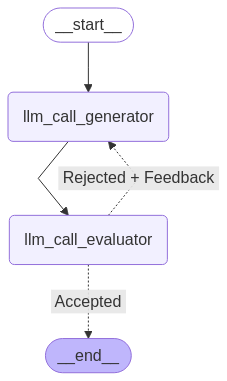

In [30]:
# Build workflow
optimizier_builder = StateGraph(State)

# Add nodes
optimizier_builder.add_node(llm_call_generator)
optimizier_builder.add_node(llm_call_evaluator)

# Add edges
optimizier_builder.add_edge("__start__", "llm_call_generator")
optimizier_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizier_builder.add_conditional_edges(
    "llm_call_evaluator", 
    route_joke, 
    {
        "Accepted": "__end__", 
        "Rejected + Feedback": "llm_call_generator"
    }
)

# Compile
optimizier_workflow = optimizier_builder.compile()

# Show the workflow
display(Image(optimizier_workflow.get_graph().draw_mermaid_png()))

In [31]:
state = optimizier_workflow.invoke({"topic": "rwth aachen"})

/opt/homebrew/Cellar/jupyterlab/4.4.0/libexec/lib/python3.13/site-packages/pydantic/json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=False, default=None, description='Decide if the joke is funny or not.'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [32]:
state['funny_or_not']

'funny'

### Agent

In [33]:
from langchain_core.tools import tool

# Define tools
@tool
def add(a: int, b: int) -> int:
    """Add two integers a and b.
    
    Args:
        a: first int
        b: second int
    """

    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract a from b.
    
    Args:
        a: first int
        b: second int
    """

    return b - a


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two integers a and b.
    
    Args:
        a: first int
        b: second int
    """

    return a * b

@tool
def divide(a: int, b: int) -> int:
    """Divide a by b.
    
    Args:
        a: first int
        b: second int
    """

    return a / b

# Augment the LLM with tools
tools = [add, subtract, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [34]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage

# Node
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not."""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of input."
                    )
                ] + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call."""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["Action", "__end__"]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call."""

    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "Action"
    return "__end__"

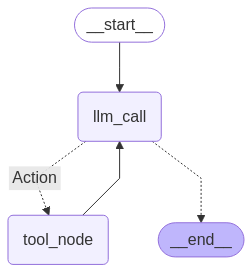

In [35]:
# Build agent
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node(llm_call)
agent_builder.add_node(tool_node)


# Add edges
agent_builder.add_edge("__start__", "llm_call")
agent_builder.add_conditional_edges(
    "llm_call", 
    should_continue, 
    {
        "Action": "tool_node", 
        "__end__": "__end__"
    }
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile
agent = agent_builder.compile()

# Show agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [36]:
messages = [HumanMessage(content="Hello! What is 5 + 5 and then times 2?")]

messages = agent.invoke({"messages": messages})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello! What is 5 + 5 and then times 2?
================================== Ai Message ==================================
Tool Calls:
  add (call_1ZA8aAzgTDuu2QHEf8NMBXsW)
 Call ID: call_1ZA8aAzgTDuu2QHEf8NMBXsW
  Args:
    a: 5
    b: 5
================================= Tool Message =================================

10
================================== Ai Message ==================================
Tool Calls:
  multiply (call_79Kv0OEiXCq6Pvg78DRDVHPH)
 Call ID: call_79Kv0OEiXCq6Pvg78DRDVHPH
  Args:
    a: 10
    b: 2
================================= Tool Message =================================

20
================================== Ai Message ==================================

The result of \( (5 + 5) \times 2 \) is 20.
